In [1]:
import csv, sys, os, re
from collections import Counter
import numpy
import numpy as np
from matplotlib import pyplot
from sklearn.cluster import KMeans, AgglomerativeClustering
from collections import defaultdict
from matplotlib.pyplot import *
import matplotlib.pyplot as plt


word_pattern = re.compile("\w[\w\-\']*\w|\w")

In [2]:
documents = []

with open("./data/metadata.csv", encoding="utf-8") as reader:
    csv_reader = csv.DictReader(reader)
    for document in csv_reader:
        try:
            with open("./data/{}".format(document["Filename"]), encoding="utf-8") as reader:
                print(document["Author"] + " / " + document["Title"])

                lines = []
                for line in reader:
                    lines.append(line.rstrip())

                text = " ".join(lines)
                document["Text"] = text
                document["Tokens"] = word_pattern.findall(text)
                document["Horror"] = "Horror" in document["Genre"] or "horror" in document["Genre"]
                
                documents.append(document)
        except Exception as e:
            print("! Problem with {}: {}".format(document["Filename"], e))

Austen, Jane / Emma
Austen, Jane / Persuasion
Austen, Jane / Pride and Prejudice
Austen, Jane / Sense and Sensibility
! Problem with baring_gould_the_book_of_werewolves_pg5324.txt: [Errno 2] No such file or directory: './data/baring_gould_the_book_of_werewolves_pg5324.txt'
Baum, Lyman Frank / Glinda of Oz
Baum, Lyman Frank / The Wonderful Wizard of Oz
Beckford, William / Vathek
! Problem with beckford_vathek_an_arabian_tale_pg42401.txt: 'utf-8' codec can't decode byte 0xd2 in position 1716: invalid continuation byte
Bierce, Ambrose / An Occurrence at Owl Creek Bridge
Bierce, Ambrose / Present at a Hanging and Other Ghost Stories
Bierce, Ambrose / The Parenticide Club
Bierce, Ambrose / The Damned Thing
Birkhead, Edith / The Tale of Terror
! Problem with edith_the_tale_of_terror_pg14154.txt: 'utf-8' codec can't decode byte 0xe9 in position 6657: invalid continuation byte
Blackwood, Algernon / The Damned
Blackwood, Algernon / The Willows
Blackwood, Algernon / Four Weird Tales
Blackwood, A

In [3]:
all_counts = Counter()

for document in documents:
    doc_counter = Counter(document["Tokens"])
    all_counts += doc_counter   
    document["TokenCounts"] = doc_counter

In [4]:
Counter([doc["Genre"] for doc in documents])


Counter({'Romance': 5,
         'Fiction; Love Story; Romanitc': 1,
         'Romantic Fiction': 1,
         "Children's Literature; Fantasy": 1,
         'Fantasy': 1,
         'Horror': 34,
         'Horror; Mystery': 2,
         'Horror; Supernatural': 2,
         'juvenile fiction': 1,
         'Fiction': 10,
         'Gothic; Horror': 8,
         'Epic; Poetry': 1,
         "Fantasy Fiction; Children's Stories": 1,
         'Mystery; Detective': 5,
         'Mystery; Fiction': 1,
         'Ghost': 1,
         'Historial Fiction': 1,
         'Social': 1,
         'Fairy Tale; Victorian Literature': 1,
         'Mystery': 2,
         'Historical Fiction; Adventure': 1,
         'Adventure': 2,
         'Science Fiction': 4,
         'Horror; Fiction': 3,
         'Horror; Non-Fiction': 1,
         'Historical Fiction': 2,
         'Political': 1,
         'War': 1,
         'Horror; Suspense': 1,
         'Crime; Fiction': 2,
         'Gothic': 1,
         'Family Drama; Tragedy': 

In [5]:
def load_word_weights(lexicon_file):

    ## Create a mapping from words to numbers
    ## {word: emotion: 0/1}
    
    # This creates a depth two dictionary where the default value is 0.
    word_weights = defaultdict(lambda: defaultdict(int))
    with open(lexicon_file, 'r') as lexicon_reader:
        for line in lexicon_reader:
            word, emotion, weight = [e.strip() for e in line.split("\t")] ## split on comma
            word_weights[word][emotion] = int(weight)
    
    return word_weights

word_weights = load_word_weights("lexicon.txt")


In [6]:
emotions = ['anger',
'anticipation',
'disgust',
'fear',
'joy',
'negative',
'positive',
'sadness',
'surprise',
'trust']

def emotion_score(doc):
    res = {}
    
    token_count = doc["TokenCounts"]
    for emotion in emotions:
        # negative
        emotion_count = 0
        total_token_count = 0
        for token, count in token_count.items():
            emotion_count += word_weights[token][emotion] * count
            total_token_count += count
        ratio = emotion_count/total_token_count
        res[emotion] = ratio
    return res

print(emotion_score(documents[0]))
print(documents[0]["Horror"])


{'anger': 0.009209839755074842, 'anticipation': 0.028339902809472618, 'disgust': 0.007336438903871904, 'fear': 0.013899628463119778, 'joy': 0.026271617977104277, 'negative': 0.02627790455714187, 'positive': 0.055045294809170864, 'sadness': 0.013428134960300247, 'surprise': 0.013069799898157403, 'trust': 0.03139518070774318}
False


In [7]:
horror_ratios = Counter()
non_horror_ratios = Counter()
num_horrors = len([1 for doc in documents if doc["Horror"]])
num_non_horrors = len([1 for doc in documents if not doc["Horror"]])

horror_scores = []
non_horror_scores = []
for doc in documents:
    score = emotion_score(doc)
    if doc["Horror"]:
        horror_ratios += Counter(score)
        horror_scores.append(score)
    else:
        non_horror_ratios += Counter(emotion_score(doc))
        non_horror_scores.append(score)

for k, v in horror_ratios.items():
    horror_ratios[k] = v/num_horrors

for k, v in non_horror_ratios.items():
    non_horror_ratios[k] = v/num_non_horrors

print(horror_ratios)
print(non_horror_ratios)


Counter({'positive': 0.040035328014289176, 'negative': 0.036997039757539894, 'trust': 0.02296053881300004, 'fear': 0.021271033429422694, 'anticipation': 0.020903003168372816, 'sadness': 0.018973146032578676, 'joy': 0.016454448487288893, 'anger': 0.014765332077139141, 'surprise': 0.011497713491444567, 'disgust': 0.011040075849638188})
Counter({'positive': 0.0408506564216608, 'negative': 0.03169358360764369, 'trust': 0.024558743429392495, 'anticipation': 0.021212063732677346, 'fear': 0.017651681357200896, 'joy': 0.017548977356903524, 'sadness': 0.01618365275868437, 'anger': 0.013022518812757747, 'surprise': 0.011114576776034241, 'disgust': 0.00893191232292915})


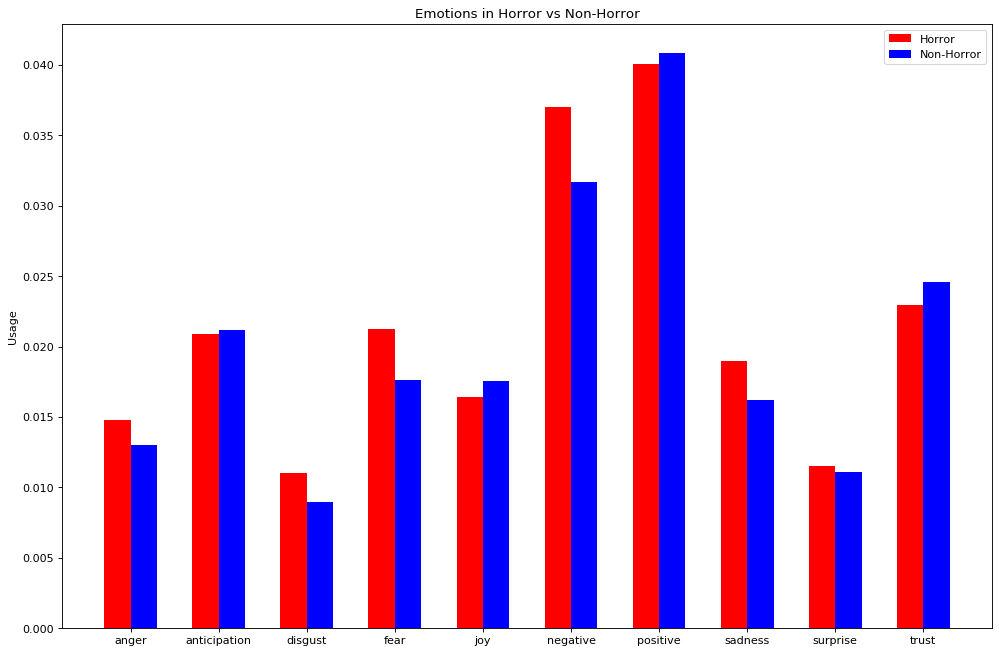

In [25]:
emotions = [k for k, v in horror_ratios.items()]
ratios = [v for k, v in horror_ratios.items()]

non_horror_ratio_vals = [v for k, v in non_horror_ratios.items()]

y_pos = numpy.arange(len(emotions))

figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

plt.bar(y_pos - .15, ratios, align='center', width=.3, color='r', label="Horror")
plt.bar(y_pos + .15, non_horror_ratio_vals, width=.3, color='b', align='center', label="Non-Horror")
plt.xticks(y_pos, emotions)
plt.ylabel('Usage')
plt.title('Emotions in Horror vs Non-Horror')

plt.legend()

plt.show()


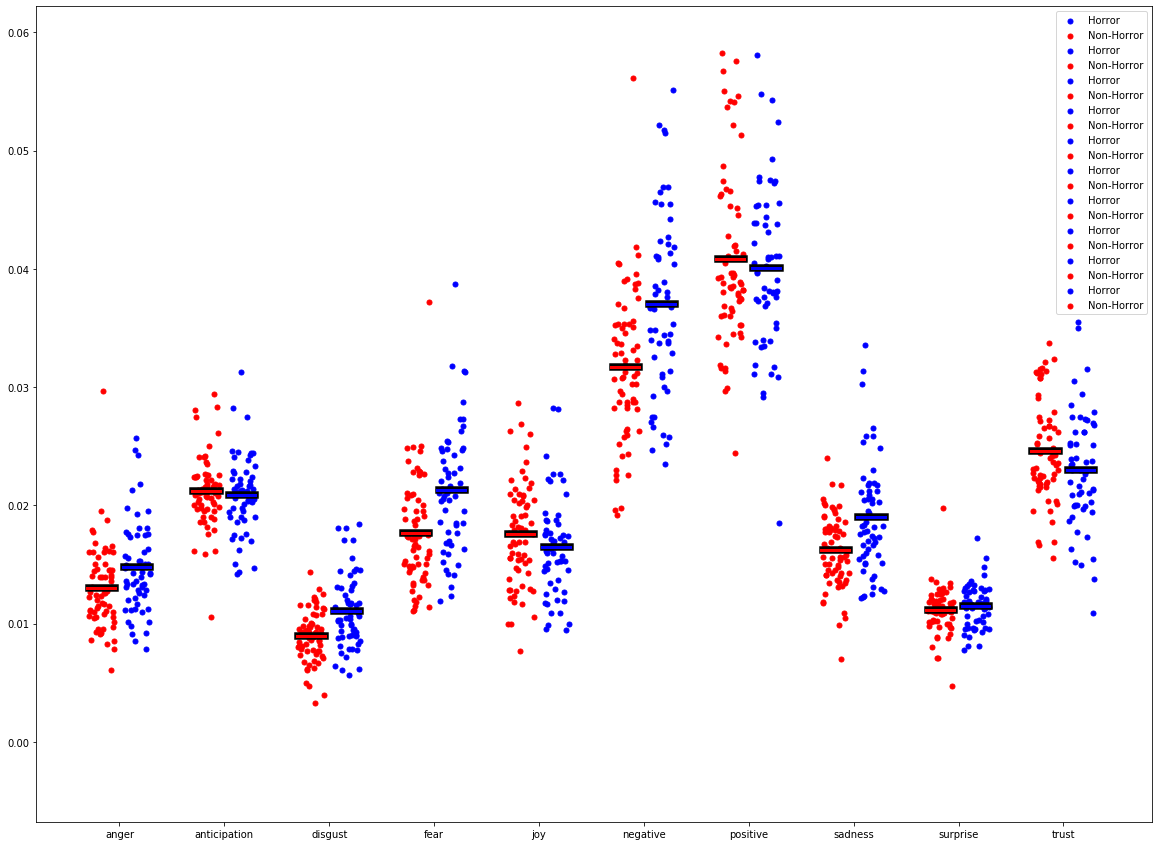

In [26]:
import numpy as np

emotions = [k for k, v in horror_ratios.items()]
ratios = [v for k, v in horror_ratios.items()]

non_horror_ratio_vals = [v for k, v in non_horror_ratios.items()]

y_pos = numpy.arange(len(emotions))


labels = [k for k, v in horror_ratios.items()]

width=0.25
fig, ax = plt.subplots()
for i, label in enumerate(labels):
    y = np.array([e[label] for e in horror_scores])
    x = np.ones(len(y))*i + .17 + (np.random.rand(len(y))*width-width/2.)
    mean = y.mean()

    ax.scatter(x, y, color="blue", s=25, label="Horror")
    ax.plot([i-width/2. + .17, i+width/2. + .17],[mean,mean], color="k", linewidth=7.5)
    ax.plot([i-width/1.8 + .17, i+width/2. + .17],[mean,mean], color="b", linewidth=3)

    
    y = np.array([e[label] for e in non_horror_scores])
    x = np.ones(len(y))*i - .17 + (np.random.rand(len(y))*width-width/2.)
    
    mean = y.mean()

    ax.scatter(x, y, color="red", s=25, label="Non-Horror")
    ax.plot([i-width/2. - .17, i+width/2. - .17],[mean,mean], color="k", linewidth=7.5)
    ax.plot([i-width/1.8 - .17, i+width/2. - .17],[mean,mean], color="red", linewidth=3)



ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

ax.legend()

fig.set_size_inches(20,15)
# fig.(num=None, figsize=(20, 20), dpi=30, facecolor='w', edgecolor='k')

plt.show()
